In [1]:
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

pyro.enable_validation(True)

In [2]:
print("torch:", torch.__version__)
print("pyro:", pyro.__version__)

if not pyro.__version__.startswith("1"):
    raise ValueError("incompatible version of pyro")

torch: 1.3.0.post2
pyro: 1.0.0


In [3]:
seed_number = 444

def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
set_random_seed(seed_number)

### Importing the grid search results from the simulator

In [4]:
file_path = "gem5-aladdin_data/stencil_stencil3d_results.csv"
results_df = pd.read_csv(file_path, delimiter=",").drop_duplicates()

### These are the "regression" analysis results

![](gem5-aladdin_data/Regression_analysis.png)

I chose `stencil_stencil3d` as the test case (workload) - it mainly depends on `cache_size` and `pipelining`.
It is easier to work with a low dimensional space at the beginning. 

In [5]:
results_df.columns

Index(['tlb_page_size', 'tlb_entries', 'tlb_assoc', 'cycle_time',
       'tlb_max_outstanding_walks', 'tlb_miss_latency', 'cache_line_sz',
       'cache_assoc', 'cache_queue_size', 'tlb_hit_latency', 'pipelined_dma',
       'cache_size', 'pipelining', 'cache_hit_latency', 'cache_bandwidth',
       'tlb_bandwidth', 'success', 'cycle', 'power', 'area'],
      dtype='object')

In [6]:
results_small = results_df[['cache_size', 'pipelining', 'cycle', 'power', 'area']]
X_train = torch.tensor(results_small[['cache_size', 'pipelining']].values.astype(np.float32))
Y_train = torch.tensor(results_small['cycle'].values.astype(np.float32))

# Deterministic GP model

Trying to fit a deterministic continuous gp model on `cache_size` and `pipelining` to predict `cycle`.

In [7]:
pyro.clear_param_store()
gp_model = gp.models.GPRegression(X_train, Y_train, 
                                 gp.kernels.Matern52(input_dim=2, 
                                                     lengthscale=torch.tensor([100000, 1]),
                                                     variance=torch.tensor(50)), 
                                 noise=torch.tensor(0.1), 
                                 jitter=1.0e-4)

In [8]:
optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.001)
losses = gp.util.train(gp_model, optimizer, num_steps=1000);

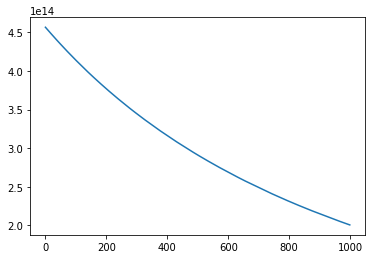

In [9]:
plt.plot(losses)

In [10]:
sorted(list(gp_model.named_pyro_params()))

[('kernel.lengthscale',
  tensor([7.5662e+04, 6.7314e-01], grad_fn=<AddBackward0>)),
 ('kernel.variance', tensor(51.2958, grad_fn=<AddBackward0>)),
 ('noise', tensor(0.2282, grad_fn=<AddBackward0>))]

In [11]:
def plot_function(f, x1_min, x1_max, x2_min, x2_max, n_points=100, strides=200):
    
    X1 = torch.linspace(x1_min, x1_max, n_points)
    X2 = torch.linspace(x2_min, x2_max, n_points)

    X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
    
    Z_mesh = f(torch.stack((X1_mesh.flatten(), X2_mesh.flatten()), dim=1)).reshape(n_points,n_points)
    
    plt.contourf(X1_mesh, X2_mesh, Z_mesh, strides)
    plt.set_cmap('jet')
    plt.colorbar()

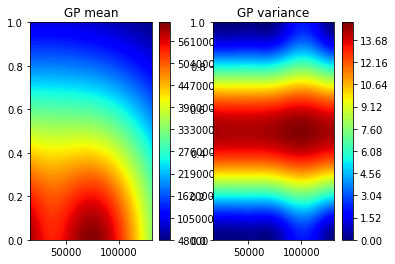

In [12]:
const_x1_min = X_train[:, 0].min()
const_x1_max = X_train[:, 0].max()
const_x2_min = X_train[:, 1].min()
const_x2_max = X_train[:, 1].max()

with torch.no_grad(), gp_model._pyro_context:
    plt.subplot(1,2,1)
    plt.title("GP mean")
    f = lambda x: gp_model(x)[0]
    plot_function(f, const_x1_min, const_x1_max, const_x2_min, const_x2_max)

    plt.subplot(1,2,2)
    plt.title("GP variance")
    f = lambda x: gp_model(x)[1]
    plot_function(f, const_x1_min, const_x1_max, const_x2_min, const_x2_max)

`x`, `y` axes are `cache_size` and `pipelining` respectively. The message is quite clear - in order to maximise `cycle` we need to turn off pipelining and do not use too much of cache.

# Stochastic GP model using one hot categorical distribution

### Preping the data

In [13]:
train_df = copy.deepcopy(results_small)
train_df.head(n=5)

,cache_size,pipelining,cycle,power,area
0,16384,0,329286,9.81282,73430.2
1,131072,1,51707,30.10500,469466.0
2,32768,1,87354,10.94530,245934.0
3,65536,0,390671,10.36130,525467.0
4,131072,0,298629,11.46500,459916.0


In [14]:
# Dealing with pipelining as one hot
train_df.loc[train_df.pipelining == 0, "pipelining_0"] = 1
train_df.loc[train_df.pipelining == 1, "pipelining_0"] = 0

train_df.loc[train_df.pipelining == 0, "pipelining_1"] = 0
train_df.loc[train_df.pipelining == 1, "pipelining_1"] = 1

# Dealing with cache size as one hot
train_df["cache_size_16384"] = 0
train_df["cache_size_32768"] = 0
train_df["cache_size_65536"] = 0
train_df["cache_size_131072"] = 0

train_df.loc[train_df.cache_size == 16384, "cache_size_16384"] = 1
train_df.loc[train_df.cache_size == 32768, "cache_size_32768"] = 1
train_df.loc[train_df.cache_size == 65536, "cache_size_65536"] = 1
train_df.loc[train_df.cache_size == 131072, "cache_size_131072"] = 1

In [15]:
train_df.head(n=5)

,cache_size,pipelining,cycle,power,area,pipelining_0,pipelining_1,cache_size_16384,cache_size_32768,cache_size_65536,cache_size_131072
0,16384,0,329286,9.81282,73430.2,1.0,0.0,1,0,0,0
1,131072,1,51707,30.10500,469466.0,0.0,1.0,0,0,0,1
2,32768,1,87354,10.94530,245934.0,0.0,1.0,0,1,0,0
3,65536,0,390671,10.36130,525467.0,1.0,0.0,0,0,1,0
4,131072,0,298629,11.46500,459916.0,1.0,0.0,0,0,0,1


### Training data

In [16]:
# X_train = torch.tensor(train_df[["pipelining_0", "pipelining_1", 
#                                  "cache_size_16384", "cache_size_32768", 
#                                  "cache_size_65536", "cache_size_131072"]].values.astype(np.float32))

X_train = torch.tensor(train_df[["cache_size_16384", "cache_size_32768", 
                                 "cache_size_65536", "cache_size_131072"]].values.astype(np.float32))

Y_train = torch.tensor(results_small['power'].values.astype(np.float32))

### Model

In [17]:
set_random_seed(333)

pyro.clear_param_store()
gp_model_svi = gp.models.GPRegression(X_train, Y_train, gp.kernels.Matern52(input_dim=4, lengthscale=torch.ones(4)))

# Set priors
gp_model_svi.kernel.lengthscale = pyro.nn.PyroSample(
    dist.RelaxedOneHotCategorical(torch.tensor([0.5]), 
                                  torch.tensor([0.25, 0.25, 0.25, 0.25])).to_event())

**This gp_model_svi.kernel.lengthscale does not work. I am not sure why.**

More general question, how to create a model with two independent RelaxedOneHotCategorical distributions.

**Should it look something like this:**

```
gp_model_svi.kernel.lengthscale = pyro.nn.PyroSample((
    dist.RelaxedOneHotCategorical(torch.tensor([0.5]), torch.tensor([0.25, 0.25, 0.25, 0.25])).to_event(), 
    dist.RelaxedOneHotCategorical(torch.tensor([0.5]), torch.tensor([0.5, 0.5])).to_event()
))
```

I am using 4 normal distributions for lengthscale, to test how the model behaves

In [18]:
# Set priors
gp_model_svi.kernel.lengthscale = pyro.nn.PyroSample(dist.Normal(1, 1).expand([4]).to_event())
gp_model_svi.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(4, 1))
gp_model_svi.noise = pyro.nn.PyroSample(dist.LogNormal(0, 1))

In [19]:
sorted(list(gp_model_svi.named_pyro_params()))

[('kernel.lengthscale_map', Parameter containing:
  tensor([-0.1071,  0.4515,  2.4287,  2.7788], requires_grad=True)),
 ('kernel.variance_map', tensor(167.1282, grad_fn=<AddBackward0>)),
 ('noise_map', tensor(1.8136, grad_fn=<AddBackward0>))]

In [20]:
# Set guides
gp_model_svi.kernel.autoguide("lengthscale", dist.Normal)
gp_model_svi.kernel.autoguide("variance", dist.Normal)
gp_model_svi.autoguide("noise", dist.Normal)

# optimise
optimizer = torch.optim.Adam(gp_model_svi.parameters(), lr=0.005)
loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
losses = gp.util.train(gp_model_svi, optimizer, loss_fn, num_steps=1000)

/usr/local/lib/python3.7/site-packages/pyro/infer/trace_mean_field_elbo.py:29: UserWarning: Failed to verify mean field restriction on the guide. To eliminate this warning, ensure model and guide sites occur in the same order.
Model sites:
  kernel.lengthscale
  kernel.variance
  noiseGuide sites:
  noise
  kernel.lengthscale
  kernel.variance
  "Guide sites:\n  " + "\n  ".join(guide_sites))


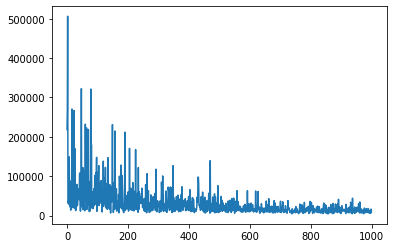

In [21]:
plt.plot(losses)

**gp_model_svi.kernel.autoguide("lengthscale", dist.Normal)** does not really make sense to me if I want to use relaxedonehotcategorical distribution. Does it mean that I have to write my own guide as there is no autoguide for RelaxedOneHotCategorical?

In [22]:
sorted(list(gp_model_svi.named_pyro_params()))

[('kernel.lengthscale_loc', Parameter containing:
  tensor([-0.8205, -0.2012,  0.2776, -0.7620], requires_grad=True)),
 ('kernel.lengthscale_scale',
  tensor([1.0389, 0.9131, 1.1062, 1.1291], grad_fn=<AddBackward0>)),
 ('kernel.variance_loc', Parameter containing:
  tensor(4.5681, requires_grad=True)),
 ('kernel.variance_scale', tensor(0.9025, grad_fn=<AddBackward0>)),
 ('noise_loc', Parameter containing:
  tensor(1.6569, requires_grad=True)),
 ('noise_scale', tensor(0.5310, grad_fn=<AddBackward0>))]